### Cylindrical Epithelium 

In this notebook, we illustrate the epithelium generation strategy.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import graph_tool.all as gt
import pandas as pd
import seaborn as sns

import IPython.display as disp
import leg_joint
from leg_joint.epithelium.generation import base_grid, cylindrical

from leg_joint.epithelium.generation import (vertex_data,  cell_data,
                                             edge_data, junction_data,
                                             face_data)

/home/guillaume/anaconda/envs/python3/lib/python3.4/site-packages/graph_tool/draw/cairo_draw.py:1318: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


## `epithelium.generation` documentation

This module contains the elements necessary to build an epithelium.

vertex_data, cell_data, edge_data, junction_data and 
face_data are dictionnaries of the form:
```python
{'data_name': (default_value, data_type)}.
```
They are used to instanciate all the necessary property maps over the graph.

vertex_data and edge_data contain data unspecific to the vertex or edge type (here cell vertices, junction edges, and triangular faces). Specific data for cells and junction edges will be instanciated as PropertyMaps of the corresponding GraphView, except for faces. Note that graphviews inherits the parent graphs propertymaps at instanciation time.

It is recommanded to add new properties by specifying them here, although they can also be specified when Epithelium is instanciated. Adding properties dynamically is possible but can lead to inconsitencies between graphviews and the parent graph's propery maps.


#### Data structures specification

Here is an example of data dictionnary for the graph vertices:

In [89]:
vertex_data

{'height': (0.0, 'float'),
 'is_active_vert': (1, 'bool'),
 'is_alive': (1, 'bool'),
 'is_cell_vert': (0, 'bool'),
 'rho': (0.0, 'float'),
 'theta': (0.0, 'float'),
 'x': (0.0, 'float'),
 'y': (0.0, 'float'),
 'z': (0.0, 'float')}

### Cell / junction vertex grid generation

Here we show how the hexagnal cell lattice is generated.

We go for a very explicit strategy. Note that we could use a more generic one by considering a Delaunay triangulation to a set of cell centers, followed by a Voronoï tessalation giving the junctions meshes.


#### Flat vertex grid 

In [4]:
print(base_grid.__doc__)


    Creates a 2D hexagonal grid with the following geometry:

               j       j       j       j
           c       c       c       c
               j       j       j       j
           j       j       j       j
               c       c       c       c
           j       j       j       j
               j       j       j

    Parameters
    ----------

    n_cells_x : int
        Number of cells along the first dimention
        (i.e the number of cell vertices on an axis
         parallel to the first dimention)

    n_cells_y : int
        Number of cells along the second dimention
        (i.e the number of cell vertices on an axis
         parallel to the 2nd dimention)

    delta_x : float, optional
        Spacing between the verticies along first axis,
        default 1
    delta_y : float, optional
        Spacing between the verticies along 2nd axis
        default 1

    Note
    ----

    the total number of vertices N_v is given by  (N_v = n_cells_x * n_cells_y * 3)


/home/guillaume/anaconda/envs/python3/lib/python3.4/site-packages/matplotlib-1.4.x-py3.4-linux-x86_64.egg/matplotlib/figure.py:1644: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


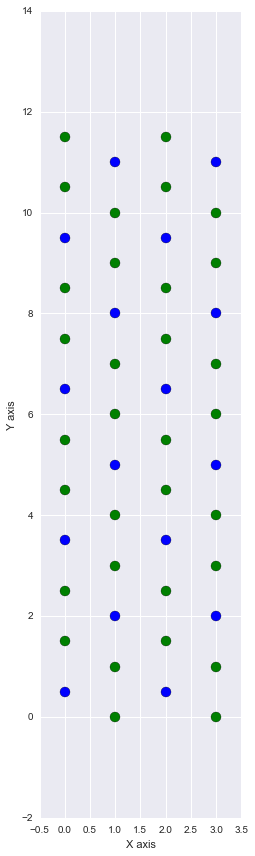

In [5]:
n_cells_x = 4
n_cells_y = 4

pos, is_cell_vert = base_grid(n_cells_x, n_cells_y)

fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(pos[:, 0][True - is_cell_vert],
           pos[:, 1][True - is_cell_vert],
           c='g', s=100)

ax.scatter(pos[:, 0][is_cell_vert],
           pos[:, 1][is_cell_vert],
           c='b', s=100)


ax.set_aspect('equal')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')


### Cylindrical mesh 

Here we go from the base grid to the complete graph, by calling graph_tool `geometric_graph` over the 3D positions. The base grid is projected from a plane to the
cylinder surface.

In [83]:
### Typical number of cells along z
n_length = 5
### Typical number of cells around the cylinder
n_circum = 7

### Distance between 2 vertices
l_0 = 1. 
### heights
h_0 = 1.


### Compute the cylinder radius from the number of vertices
### (This is computed inside `cylinidrical`, but we put it there for reference)

rho_c = n_circum * l_0 / (2 * np.pi)
### Compute the lumen radius from the prefered height
rho_lumen = rho_c - h_0
delta_theta = 2 * np.pi / n_circum
delta_z = delta_theta * rho_c * np.sqrt(3)/2.


graph = cylindrical(n_length, n_circum, l_0=1, h_0=1)


2015-05-21 13:09:18,398 -leg_joint.epithelium.generation -reorient_edges -- INFO -filpped 90 edges


#### A basic drawing function using graph_tool

In [6]:
def draw(graph, coords, **kwargs):
    '''
    Draws the graph with different colors for cells and junctions
    Note that the vertex and edge properties map `is_cell_vert`
    and `is_junction_edge` are assumed to be present in the graph's
    internal properties.
    
    Parameters
    ----------
    
    graph: :class:`gt.Graph`
    coords: sequence of two strings
        the names of the internal vertex property maps
        used as coordinates to plot the graph
    
    '''
    
    is_cell_vert = graph.vp['is_cell_vert']
    is_junction_edge = graph.ep['is_junction_edge']
    pos_vp = gt.group_vector_property([graph.vp[c] for c in coords])
    
    not_junction = is_junction_edge.copy()
    not_junction.a = 1 - is_junction_edge.a
    gt.graph_draw(graph, pos_vp, inline=True,
                  vertex_fill_color=is_cell_vert,
                  edge_color=not_junction,
                  output_size=(600, 400), **kwargs)

#### Pseudo 3D representation

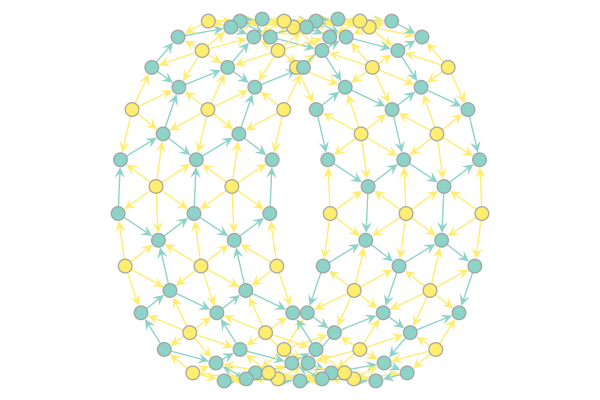

In [7]:
## mesh's z axis rotation around the image y axis 
z_angle = np.pi/5
## Rotation of the mesh around the mesh's z axis
d_theta = np.pi/3

### Projected coordinates
graph.vp['psd_x'] = graph.vp['x'].copy()
graph.vp['psd_y'] = graph.vp['y'].copy()
pseudo_x = graph.vp['psd_x']
pseudo_y = graph.vp['psd_y']
graph.vp['rho'].a = np.hypot(graph.vp['x'].a,
                             graph.vp['y'].a)
pseudo_x.a = graph.vp['z'].a * np.cos(z_angle) - graph.vp['rho'].a * np.sin(
        graph.vp['theta'].a + d_theta) * np.sin(z_angle)
pseudo_y.a = graph.vp['rho'].a * np.cos(graph.vp['theta'].a + d_theta)

draw(graph, ['psd_x', 'psd_y'], vorder=graph.vp['y'])



#### Flat projection of the cylinder surface

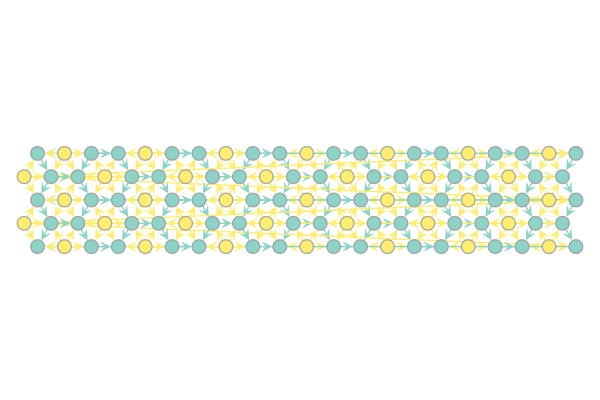

In [8]:
graph.vp['sigma'] = graph.vp['x'].copy()
graph.vp['sigma'].a = np.arctan2(graph.vp['y'].a, graph.vp['x'].a) * graph.vp['rho'].a

draw(graph, ['sigma', 'z'])

### Geometry

In [9]:
from leg_joint.geometry.geometry import Mesh

In [10]:
%pdb

Automatic pdb calling has been turned ON


In [84]:
mesh = Mesh(graph, rho_lumen)

In [87]:
mesh.update_geometry()

In [13]:
mesh.cell_graph.vp.keys()

dict_keys(['sigma', 'vol_elasticity', 'is_cell_vert', 'height', 'y', 'psd_x', 'area', 'vol', 'rho', 'perimeter', 'psd_y', 'contractility', 'x', 'is_alive', 'z', 'num_sides', 'is_active_vert', 'theta'])

In [90]:
mesh.cell_graph.vp['vol']

<PropertyMap object with key type 'Vertex' and value type 'double', for Graph 0x7f541c13cac8, at 0x7f5420b24c18, with values:
[ 4.18177004  4.18177004  4.18177004  4.18177004  4.18177004  4.18177004
  4.18177004  8.36354007  8.36354007  8.36354007  8.36354007  8.36354007
  8.36354007  8.36354007  8.36354007  8.36354007  8.36354007  8.36354007
  8.36354007  8.36354007  8.36354007  8.36354007  8.36354007  8.36354007
  8.36354007  8.36354007  8.36354007  8.36354007  4.18177004  4.18177004
  4.18177004  4.18177004  4.18177004  4.18177004  4.18177004]>

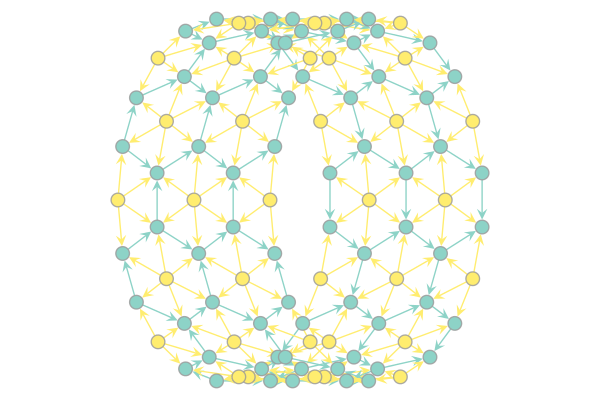

In [52]:
## mesh's z axis rotation around the image y axis 
z_angle = np.pi/5
## Rotation of the mesh around the mesh's z axis
d_theta = np.pi/6

### Projected coordinates
mesh.graph.vp['psd_x'] = mesh.graph.vp['x'].copy()
mesh.graph.vp['psd_y'] = mesh.graph.vp['y'].copy()
pseudo_x = mesh.graph.vp['psd_x']
pseudo_y = mesh.graph.vp['psd_y']
graph.vp['rho'].a = np.hypot(mesh.graph.vp['x'].a,
                             mesh.graph.vp['y'].a)
pseudo_x.a = mesh.graph.vp['z'].a * np.cos(z_angle) - mesh.graph.vp['rho'].a * np.sin(
        mesh.graph.vp['theta'].a + d_theta) * np.sin(z_angle)
pseudo_y.a = mesh.graph.vp['rho'].a * np.cos(mesh.graph.vp['theta'].a + d_theta)

draw(mesh.graph, ['psd_x', 'psd_y'])
#draw(graph, ['x', 'y'])

In [53]:
mesh.graph.get_fast_edge_removal()

True

/home/guillaume/anaconda/envs/python3/lib/python3.4/site-packages/matplotlib-1.4.x-py3.4-linux-x86_64.egg/matplotlib/figure.py:1644: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


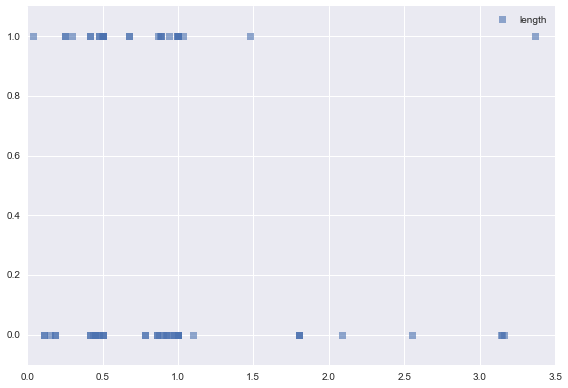

In [54]:
fig, ax = plt.subplots()
#ax.plot(mesh.graph.ep['dx'].fa, mesh.graph.ep['is_junction_edge'].fa, 'o', alpha=0.6, label='x')
#ax.plot(mesh.graph.ep['dy'].fa, mesh.graph.ep['is_junction_edge'].fa, 'o', alpha=0.6, label='y')
#ax.plot(mesh.graph.ep['dz'].fa, mesh.graph.ep['is_junction_edge'].fa, 'o', alpha=0.6, label='z')
ax.plot(mesh.graph.ep['edge_length'].fa, mesh.graph.ep['is_junction_edge'].fa,
        's', alpha=0.6, label='length')

ax.set_ylim(-0.1, 1.1)
ax.legend()

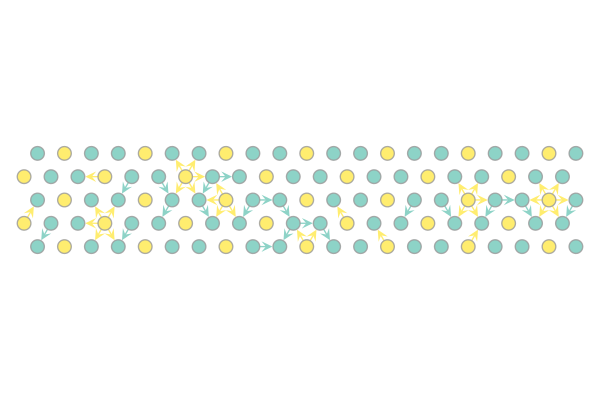

In [55]:
long = mesh.graph.new_edge_property('bool')
long.a = mesh.graph.ep['edge_length'].a > 1.1
long.a += mesh.graph.ep['edge_length'].a < 0.9
mesh.graph.set_edge_filter(long)

draw(mesh.graph, ['sigma', 'z'])
mesh.graph.clear_filters()

In [74]:
leg_joint.epithelium.generation.reorient_edges(mesh.graph,
               mesh.graph.vp['is_cell_vert'],
               mesh.graph.ep['is_junction_edge'])

2015-05-21 12:54:22,241 -leg_joint.epithelium.generation -reorient_edges -- INFO -filpped 0 edges


In [79]:
vp = mesh.graph.vp['x']

In [82]:
vp.value_type()

'double'

In [77]:
mesh.update_length()
long = mesh.graph.new_edge_property('bool')
long.a = mesh.graph.ep['edge_length'].a > 1.1
long.a += mesh.graph.ep['edge_length'].a < 0.9
mesh.graph.set_edge_filter(long)

for edge in mesh.graph.edges():
    if long[edge]:
        
        print(mesh.graph.edge_index[edge], edge)
        

21 (6, 7)
14 (6, 5)
22 (7, 8)
28 (9, 31)
29 (9, 30)
30 (9, 10)
23 (9, 8)
33 (10, 31)
32 (10, 11)
34 (11, 33)
37 (12, 13)
38 (12, 33)
39 (12, 34)
35 (12, 11)
42 (13, 34)
41 (13, 14)
153 (33, 34)
158 (33, 53)
170 (35, 36)
174 (35, 56)
181 (35, 55)
36 (35, 13)
40 (35, 14)
157 (35, 34)
186 (36, 37)
192 (36, 56)
210 (47, 69)
238 (49, 70)
237 (51, 50)
257 (52, 73)
254 (52, 53)
241 (58, 79)
260 (61, 62)
259 (61, 82)
262 (62, 63)
263 (63, 104)
266 (63, 64)
267 (64, 85)
270 (65, 86)
271 (65, 85)
272 (65, 66)
123 (65, 43)
155 (65, 44)
268 (65, 64)
177 (74, 95)
178 (74, 75)
182 (74, 94)
245 (74, 52)
253 (74, 53)
196 (75, 76)
201 (76, 97)
215 (77, 98)
216 (77, 97)
217 (77, 78)
189 (77, 55)
207 (77, 56)
191 (77, 76)
232 (78, 79)
230 (78, 98)
49 (81, 101)
51 (81, 82)
59 (85, 86)
61 (87, 88)
269 (87, 66)
101 (87, 67)
54 (87, 86)
65 (91, 92)
175 (97, 98)
206 (99, 78)
162 (99, 98)
239 (103, 104)


In [132]:
mesh.graph.ep['is_junction_edge'].fa.shape

(273,)

In [43]:
mesh.update_num_sides()

In [105]:
mesh.cell_graph.vp['num_sides'].fa

PropertyArray([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [106]:
mesh.graph.set_edge_filter(mesh.graph.ep['is_junction_edge'], inverted=True)
print(mesh.graph.degree_property_map('out').fa)
mesh.graph.clear_filters()

[4 0 0 4 0 0 4 0 0 4 0 0 4 0 0 4 0 0 4 0 0 0 0 6 0 0 6 0 0 6 0 0 6 0 0 6 0
 0 6 0 0 6 6 0 0 6 0 0 6 0 0 6 0 0 6 0 0 6 0 0 6 0 0 0 0 6 0 0 6 0 0 6 0 0
 6 0 0 6 0 0 6 0 0 6 4 0 0 4 0 0 4 0 0 4 0 0 4 0 0 4 0 0 4 0 0]
